In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns

In [14]:
# CPI: https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1913-
cpi_map = {
    2013: 233,
    2014: 236.7,
    2015: 237,
    2016: 240,
    2017: 245.1,
    2018: 251.1,
    2019: 255.7,
    2020: 258.8,
    2021: 271,
    2022: 292.7,
    2023: 304.7,
    2024: 313.7,
    2025: 322.3
}

In [51]:
cpt_spine_dict = {
    "cervical": {
        "decompression": ["63001", "63015", "63045", "63048", "63020", "63035", "63040", "63043", "63050", "63051", "63075", "63076", "63081", "63082"],
        "fusion": ["22551", "22552", "22554", "22585", "22590", "22595"],
        "instrumentation": ["22845", "22846", "22847", "22840", "22842", "22843", "22844", "22853", "22854", "22849"],
        "bone_grafting": ["20930", "20931", "20936", "20937", "20938", "20939"]
    },
    "thoracic": {
        "decompression": ["63003", "63016", "63046", "63048", "63085", "63086", "63087", "62380"],
        "fusion": ["22556", "22532", "22534", "22612", "22614", "22800", "22802", "22804", "22810", "22812"],
        "instrumentation": ["22840", "22842", "22843", "22844", "22845", "22846", "22847", "22853", "22854", "22849"],
        "bone_grafting": ["20930", "20931", "20936", "20937", "20938", "20939"]
    },
    "lumbar": {
        "decompression": ["63005", "63017", "63047", "63048", "63030", "63035", "63042", "63044", "63052", "63053", "62380", "63090", "63091"],
        "fusion": ["22558", "22585", "22533", "22534", "22612", "22614", "22630", "22632", "22633", "22634", "22800", "22802", "22804", "22810", "22812"],
        "instrumentation": ["22840", "22842", "22843", "22844", "22845", "22846", "22847", "22853", "22854", "22859", "22849"],
        "bone_grafting": ["20930", "20931", "20936", "20937", "20938", "20939"]
    }
}

# Lump spine regions for now
# cpt_spine = {}
# for region in cpt_spine_dict:
#     for proc in cpt_spine_dict[region]:
#         if proc not in cpt_spine:
#             cpt_spine[proc] = []

#         cpt_spine[proc].extend(cpt_spine_dict[region][proc])

cpt_spine = {}
for region in cpt_spine_dict:
    for proc in cpt_spine_dict[region]:
        cpt_spine[f"{proc}_{region}"] = cpt_spine_dict[region][proc]

cpt_neurovasc = {
    'aneurysm_coiling_embo': ['61624', '61626'],
    'embo_dr': ['75894', '75898'],
    'intracranial_stent_angioplasty': ['61630', '61635', '61640', '61641', '61642'],
    'intraarterial_pharm_infusion': ['61650', '61651'],
    'temp_balloon': ['61623'],
    'cerebral_angio': ['36221', '36222', '36223', '36224', '36225', '36226', '36227', '36228']
}

# Ignore cerebral angio codes for now
ignore_codes = ['36221', '36222', '36223', '36224', '36225', '36226', '36227', '36228']

cpt_map = {}

for category, codes in {**cpt_spine, **cpt_neurovasc}.items():
    for code in codes:
        if code not in ignore_codes:
            cpt_map[int(code)] = category

In [52]:
current_dir = os.getcwd()

In [53]:
spine_data = pd.read_csv(os.path.join(current_dir, "processed-data", "spine_cpt_processed.csv"))
neurovasc_data = pd.read_csv(os.path.join(current_dir, "processed-data", "neurovasc_cpt_processed.csv"))

In [54]:
spine_data['Tot_Srvcs_Spend'] = spine_data['Tot_Srvcs'] * spine_data['Avg_Mdcr_Stdzd_Amt'] 
neurovasc_data['Tot_Srvcs_Spend'] = neurovasc_data['Tot_Srvcs'] * neurovasc_data['Avg_Mdcr_Stdzd_Amt'] 

In [55]:
for data in [spine_data, neurovasc_data]:
    data['procedure'] = data['HCPCS_Cd'].map(cpt_map)

In [56]:
groupby_key = 'procedure'

In [57]:
util_2023_2013_adj_spine = (
    spine_data
    .groupby([groupby_key, 'year'], as_index=False)
    .agg(
        Sum_Utilization=('Tot_Srvcs', 'sum'),
        Sum_Spend=('Tot_Srvcs_Spend', 'sum'),
        Sum_Provider=('Rndrng_NPI', lambda x: x.nunique())
    )
)

util_2023_2013_adj_neurovasc = (
    neurovasc_data
    .groupby([groupby_key, 'year'], as_index=False)
    .agg(Sum_Utilization=('Tot_Srvcs', 'sum'),
         Sum_Spend=('Tot_Srvcs_Spend', 'sum'),
         Sum_Provider=('Rndrng_NPI', lambda x: x.nunique()))
)

In [58]:
util_2023_2013_adj_spine['CPI'] = util_2023_2013_adj_spine['year'].map(cpi_map).fillna(0)
util_2023_2013_adj_neurovasc['CPI'] = util_2023_2013_adj_neurovasc['year'].map(cpi_map).fillna(0)

In [59]:
util_2023_2013_adj_spine['Sum_Spend_adjusted'] = util_2023_2013_adj_spine['Sum_Spend'] / util_2023_2013_adj_spine['CPI'] * cpi_map[2023]
util_2023_2013_adj_neurovasc['Sum_Spend_adjusted'] = util_2023_2013_adj_neurovasc['Sum_Spend'] / util_2023_2013_adj_neurovasc['CPI'] * cpi_map[2023]

In [60]:
util_2023_2013_adj_spine['Avg_Price_per_service_adjusted'] = (
    util_2023_2013_adj_spine['Sum_Spend_adjusted'] / util_2023_2013_adj_spine['Sum_Utilization']
)

util_2023_2013_adj_neurovasc['Avg_Price_per_service_adjusted'] = (
    util_2023_2013_adj_neurovasc['Sum_Spend_adjusted'] / util_2023_2013_adj_neurovasc['Sum_Utilization']
)

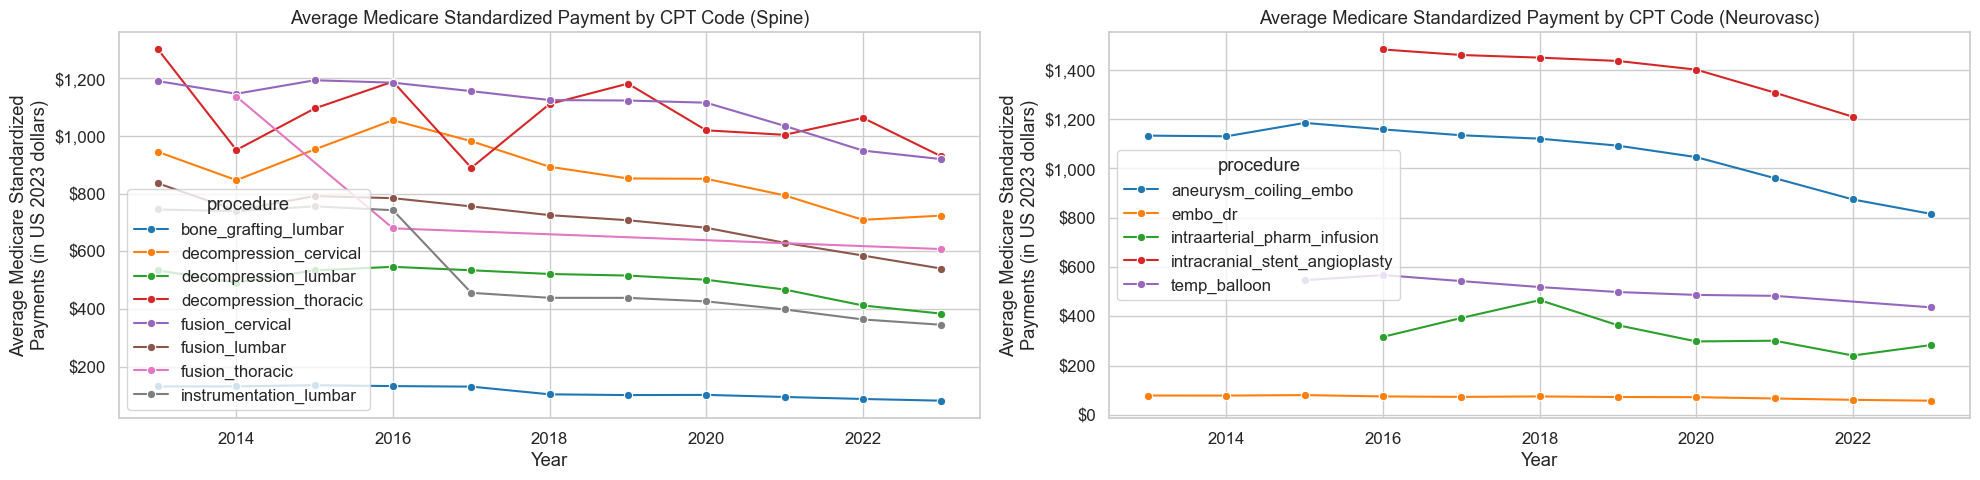

In [63]:
# Set plot style
sns.set_theme(style="whitegrid", font_scale=1.1)
fig, axs = plt.subplots(1, 2, figsize=(20, 5)) 

# Create the plot for spine
sns.lineplot(
    data=util_2023_2013_adj_spine,
    x="year",
    y="Avg_Price_per_service_adjusted",
    hue=groupby_key,
    palette="tab10",
    marker="o",
    ax=axs[0]
)

# Format y-axis as currency
axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

# Title and labels
axs[0].set_title("Average Medicare Standardized Payment by CPT Code (Spine)")
axs[0].set_ylabel("Average Medicare Standardized\nPayments (in US 2023 dollars)")
axs[0].set_xlabel("Year")

# Adjust legend
axs[0].legend(title=groupby_key)

# Create the plot for neurovasc
sns.lineplot(
    data=util_2023_2013_adj_neurovasc,
    x="year",
    y="Avg_Price_per_service_adjusted",
    hue=groupby_key,
    palette="tab10",
    marker="o",
    ax=axs[1]
)

# Format y-axis as currency
axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.0f}"))

# Title and labels
axs[1].set_title("Average Medicare Standardized Payment by CPT Code (Neurovasc)")
axs[1].set_ylabel("Average Medicare Standardized\nPayments (in US 2023 dollars)")
axs[1].set_xlabel("Year")

# Adjust legend
axs[1].legend(title=groupby_key)

plt.tight_layout()

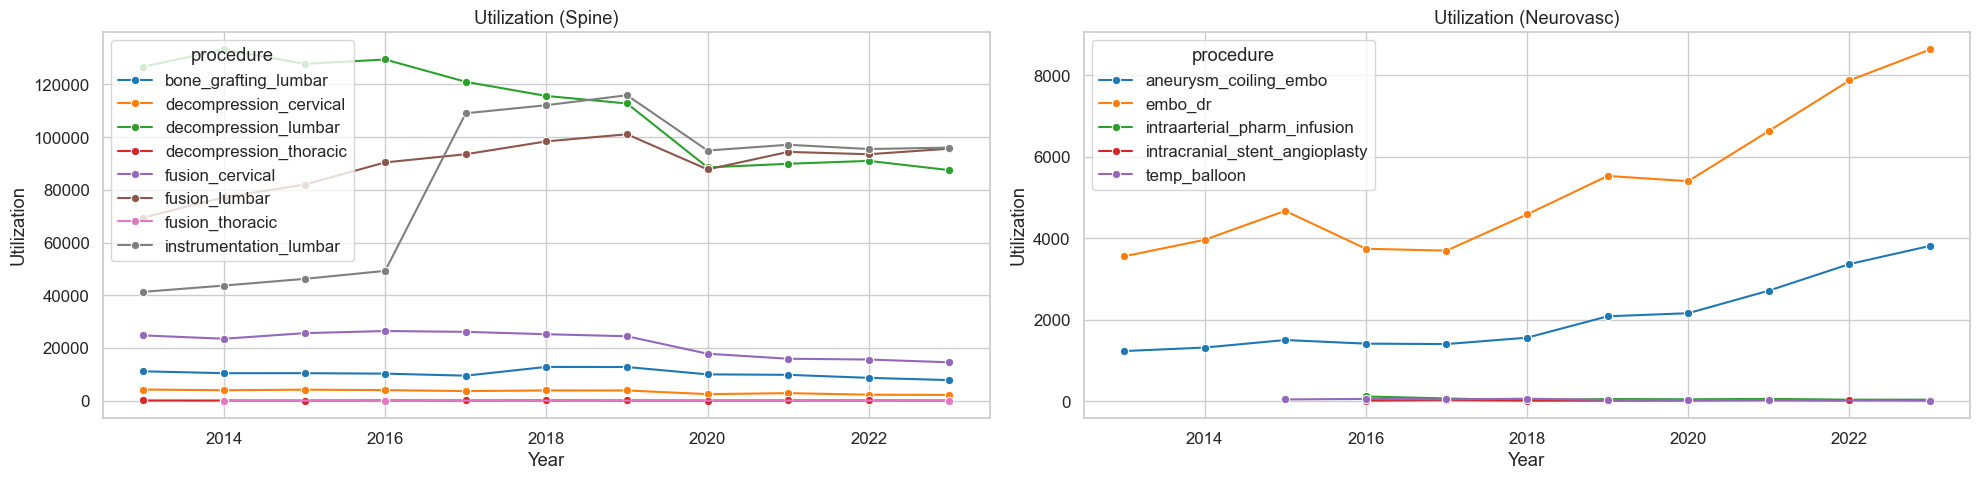

In [62]:
# Set plot style
sns.set_theme(style="whitegrid", font_scale=1.1)
fig, axs = plt.subplots(1, 2, figsize=(20, 5)) 

# Create the plot for spine
sns.lineplot(
    data=util_2023_2013_adj_spine,
    x="year",
    y="Sum_Utilization",
    hue=groupby_key,
    palette="tab10",
    marker="o",
    ax=axs[0]
)

# Title and labels
axs[0].set_title("Utilization (Spine)")
axs[0].set_ylabel("Utilization")
axs[0].set_xlabel("Year")

# Adjust legend
axs[0].legend(title=groupby_key)

# Create the plot for neurovasc
sns.lineplot(
    data=util_2023_2013_adj_neurovasc,
    x="year",
    y="Sum_Utilization",
    hue=groupby_key,
    palette="tab10",
    marker="o",
    ax=axs[1]
)

# Title and labels
axs[1].set_title("Utilization (Neurovasc)")
axs[1].set_ylabel("Utilization")
axs[1].set_xlabel("Year")

# Adjust legend
axs[1].legend(title=groupby_key)

plt.tight_layout()